In [ ]:
from sbi_feature_importance.experiment_helper import SimpleDB

from ephys_helper.hh_simulator import HHSimulator

import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time
import IPython.display as IPd
from svgutils.compose import *

In [ ]:
results_db = SimpleDB("../results/fig4", "r")

In [4]:
results = results_db.find("fts")
fts_dct = {}
for key in results:
    fts = results[key].split(" \n")
    fts = {int(val.split(": ")[0]):float(val.split(": ")[1]) for val in fts[:-1]}
    fts_dct.update({key:fts})

In [5]:
mkey = "0_2_1_1_0_best_fts"
best_fts = [val for key,val in fts_dct.items() if mkey in key and "best_mcmc" in key][0]
random_fts = [val for key,val in fts_dct.items() if mkey in key and "random_mcmc" in key][0]

In [6]:
hh = HHSimulator()
used_fts = [0,1,2,3,8,13,18,19,21,22]

xticklabels_rd = [hh.features()[used_fts[ft]] for ft in random_fts.keys()]
xticklabels = [hh.features()[used_fts[ft]] for ft in best_fts.keys()]

xticklabels_rd = [r"$\mathrm{" + x[1:-1] + r"}$" for x in xticklabels_rd]
xticklabels = [r"$\mathrm{" + x[1:-1] + r"}$" for x in xticklabels]

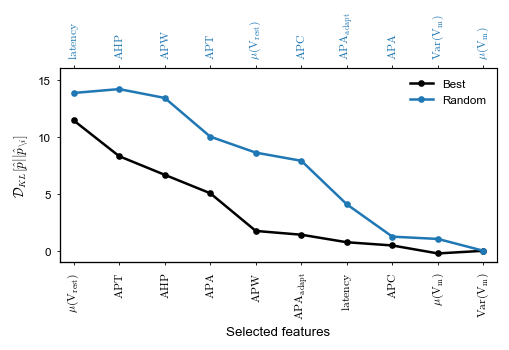

In [11]:
with mpl.rc_context(fname=".mpl_rc"):
    fig, ax1 = plt.subplots(figsize=(4.7,2.1))
    ax1.plot(range(len(used_fts)), best_fts.values(), ".-", label="Best", c="black", ms=6)
    ax1.plot(range(len(used_fts)), random_fts.values(), ".-", label="Random", c="tab:blue", ms=6)
    ax1.set_ylabel(r"$\mathcal{D}_{KL}[\hat{p}\vert\vert \hat{p}_{\backslash i}]$")
    ax1.set_xlabel(r"Selected features")
    
    ax1.set_xticks(range(len(used_fts)))
    ax1.set_xticklabels(xticklabels, rotation=90, color="black")
    ax1.set_xlim(-0.3,9.3)

    ax2 = ax1.twiny()
    ax2.set_xticks(range(len(used_fts)))
    ax2.set_xticklabels(xticklabels_rd, rotation=90, color="tab:blue")
    ax2.set_xlim(-0.3,9.3)
    ax2.set_ylim(-1,16)

    ax1.legend()
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
plt.savefig("../paper/fig4/svg/panel_a.svg")

plt.show()

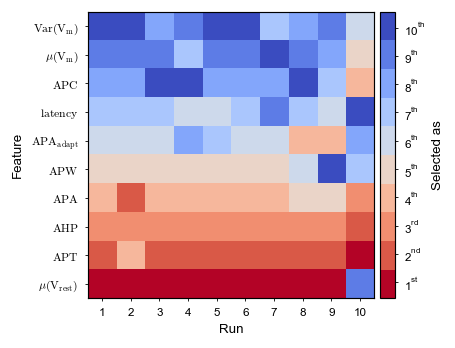

In [12]:
agg_tree_data = torch.tensor([list(val.keys()) for key,val in fts_dct.items() if "best_mcmc" in key and "2_1" in key])
hist = torch.zeros(10,10)
for ft in range(10):
    for run in range(10):
        hist[ft,run] = (torch.arange(10)[agg_tree_data[run] == ft]).sum()

idx_hist = torch.hstack([torch.tensor([used_fts]).T, hist])
new_idx = torch.argsort(idx_hist[:,1:].mean(1), descending=True)
sorted_hist, new_ft_idx = idx_hist[new_idx, 1:], idx_hist[new_idx, 0]
new_idx = torch.argsort(sorted_hist[-4:,:].sum(0))
resorted_hist, new_x_idx = sorted_hist[:, new_idx], sorted_hist[0, new_idx]

with mpl.rc_context(fname=".mpl_rc"):
    fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
    cmap = cm.get_cmap("coolwarm_r", 10)
    im = plt.imshow(resorted_hist, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(r"Selected as", rotation=90)
    loc = torch.arange(0, 10, 1).numpy() + torch.linspace(0.5,-0.5,10).numpy()
    cbar.set_ticks(loc)
    cbar.set_ticklabels([r"1$^{st}$",r"2$^{nd}$",r"3$^{rd}$"]+[f"{x}"+r"$^{th}$" for x in range(4,11)])
    ax.set_yticks(range(10))
    ax.set_yticklabels([r"$\mathrm{" + hh.features()[int(x)][1:-1] + r"}$" for x in new_ft_idx])
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(1,11))
    ax.set_xlabel(r"Run")
    ax.set_ylabel(r"Feature")
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    plt.savefig("../paper/fig4/svg/panel_b.svg")
    plt.show()

In [25]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("20.3cm", "7.1cm",
           
Panel(
        SVG("../paper/fig4/svg/panel_a.svg").scale(svg_scale),
        Text("a", 5.0, -11.0, **kwargs_text),
).move(0, 38),

Panel(
        SVG("../paper/fig4/svg/panel_b.svg").scale(svg_scale),
        Text("b", -5.0, 17.0, **kwargs_text),
).move(420, 10),
)

!mkdir -p fig
f.save("../paper/fig4/svg/fig.svg")
svg("../paper/fig4/svg/fig.svg")